In [1]:
import time
import torch
import torchvision.transforms as transforms
from  torch import nn,optim
import torch.nn.functional as F

In [30]:
class Inception(nn.Module):
    # c1 - c4为每条线路⾥的层的输出通道数
    def __init__(self,in_c,c1,c2,c3,c4):
        super().__init__()
        #线路1,1*1
        self.p1_1=nn.Conv2d(in_c,c1,kernel_size=1)
        #线路2,1*1 + 3*3
        self.p2_1=nn.Conv2d(in_c,c2[0],kernel_size=1)
        self.p2_2=nn.Conv2d(c2[0],c2[1],kernel_size=3,padding=1)
        #线路3 ,1*1 + 5*5
        self.p3_1=nn.Conv2d(in_c,c3[0],kernel_size=1)
        self.p3_2=nn.Conv2d(c3[0],c3[1],kernel_size=5,padding=2)
        #线路4 3*3,maxpool + 1*1
        self.p4_1=nn.MaxPool2d(kernel_size=3,stride=1,padding=1)
        self.p4_2=nn.Conv2d(in_c,c4,kernel_size=1)
    
    def forward(self,x):
        p1=F.relu(self.p1_1(x))
        p2=F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3=F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4=F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1,p2,p3,p4),dim=1)
        

In [31]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return F.avg_pool2d(x,x.size()[2:])

In [32]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,x):
        return x.view(x.size()[0],-1)

In [33]:
# b1_1 : (96-7+3*2+2)/2=97/2=48 ,1,64,48,48
#b1_2:1,64,(48-3+1*2+2)/2=49/2=24,1,64,24,24
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(), 
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
#input:1,64,24,24
#b2_1:(24-1+1)/1=24
#b2_2=(24-3+1*2+1)/1=24
#b2_3=(24-3+1*2+2)/2=12,  64,192,12,12
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
#input:64,192,12,12
#b3_11=192,64,(12-1+1)/1=12,12
#b3_21=192,96,(12-1+1)/1=12,12,12
#b3_22=96,128,(12-3+1*2+1)/1=12,12
#b3_31=192,16,(12-1+1)/1=12,12
#b3_32=16,32,(12-5+2*2+1)/1=12,12
#b4_11=64,192,(12-3+1*2+1)/1=12,12
#b4_12=192,32,(12-1+1)/1=12,12



 - b3 计算过程:
 - Inception(192, 64, (96, 128), (16, 32), 32) 
 - input:64,192,12,12
 - b3_11=192,64,(12-1+1)/1=12,12
 - b3_21=192,96,(12-1+1)/1=12,12,12
 - b3_22=96,128,(12-3+1*2+1)/1=12,12
 - b3_31=192,16,(12-1+1)/1=12,12
 - b3_32=16,32,(12-5+2*2+1)/1=12,12
 - b4_11=64,192,(12-3+1*2+1)/1=12,12
 - b4_12=192,32,(12-1+1)/1=12,12
 - 输出为: input,256,12,12 (256为路的最后1成输出相加)
 
- Inception(256, 128, (128, 192), (32, 96), 64)
- b3_11=256,128,12,12
- b3_21=256,128,12,12
- b3_22=128,192,(12-3+1*2+1)/1=12,12
- b3_31=256,32,12,12
- b3_32=32,96,(12-5+2*2+1)/1=12,12
- b3_41=256,128,12,12
- b3_42=128,64,12,12

- 第二层依次为:
- b3_11=256,128,12,12
- b3_22=128,192,12,12
- b3_32=32,96,12,12
- b3_42=128,64,12,12
- ------
- 将dim=1 的通道加起来,就是input ,480,12,12 
- 经过nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
- input,480,(12-3+1*2+2)/2=6,6,与模型计算相等
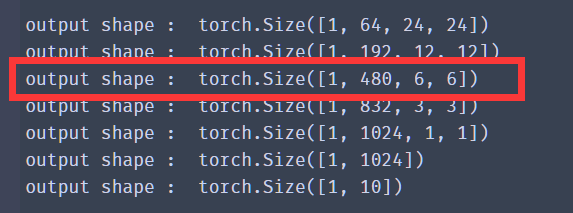
    

In [ ]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b5=nn.Sequential(Inception(832,256,(160,320),(32,128),128),
                Inception(832,384,(192,384),(48,128),128),
                GlobalAvgPool2d())
net=nn.Sequential(b1,b2,b3,b4,b5,FlattenLayer(),nn.Linear(1024,10))

In [34]:
X=torch.rand(1,1,96,96)
for blk in net.children():
    X=blk(X)
    print('output shape : ',X.shape)

output shape :  torch.Size([1, 64, 24, 24])
output shape :  torch.Size([1, 192, 12, 12])
output shape :  torch.Size([1, 480, 6, 6])
output shape :  torch.Size([1, 832, 3, 3])
output shape :  torch.Size([1, 1024, 1, 1])
output shape :  torch.Size([1, 1024])
output shape :  torch.Size([1, 10])


In [35]:
128+192+96+64

480